<a href="https://colab.research.google.com/github/AvantiShri/gcp_analysis_rough/blob/main/NullDistPowerSpectrum_Valentines2009_powerspectrum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download and unzip the relevant GCP data

In [1]:
# See https://global-mind.org/valentines.09.html for a description of the event
#grab the data - uncomment as needed

! wget -N -r -nH --cut-dirs=1 --limit-rate=125k https://global-mind.org/data/eggsummary/2009/basketdata-2009-02-14.csv.gz
! wget -N -r -nH --cut-dirs=1 --limit-rate=125k https://global-mind.org/data/eggsummary/2009/basketdata-2009-02-13.csv.gz #control1
! wget -N -r -nH --cut-dirs=1 --limit-rate=125k https://global-mind.org/data/eggsummary/2009/basketdata-2009-02-15.csv.gz #control2

--2023-10-19 23:39:24--  https://global-mind.org/data/eggsummary/2009/basketdata-2009-02-14.csv.gz
Resolving global-mind.org (global-mind.org)... 162.245.217.130
Connecting to global-mind.org (global-mind.org)|162.245.217.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5110222 (4.9M) [application/x-gzip]
Saving to: ‘eggsummary/2009/basketdata-2009-02-14.csv.gz’

eggsummary/2009/bas 100%[===================>]   4.87M   125KB/s    in 40s     

2023-10-19 23:40:04 (125 KB/s) - ‘eggsummary/2009/basketdata-2009-02-14.csv.gz’ saved [5110222/5110222]

FINISHED --2023-10-19 23:40:04--
Total wall clock time: 40s
Downloaded: 1 files, 4.9M in 40s (125 KB/s)
--2023-10-19 23:40:04--  https://global-mind.org/data/eggsummary/2009/basketdata-2009-02-13.csv.gz
Resolving global-mind.org (global-mind.org)... 162.245.217.130
Connecting to global-mind.org (global-mind.org)|162.245.217.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5141417 (4.9M) 

In [2]:
#unzip the data - uncomment as needed
!gunzip eggsummary/2009/basketdata-2009-02-14.csv.gz
!gunzip eggsummary/2009/basketdata-2009-02-13.csv.gz
!gunzip eggsummary/2009/basketdata-2009-02-15.csv.gz

In [3]:
!ls eggsummary/2009

basketdata-2009-02-13.csv  basketdata-2009-02-14.csv  basketdata-2009-02-15.csv


In [4]:
#sanity check the download
!head eggsummary/2009/basketdata-2009-02-14.csv

10,1,10,"Samples per record"
10,2,10,"Seconds per record"
10,3,30,"Records per packet"
10,4,200,"Trial size"
11,1,61,"Eggs reporting"
11,2,1234569600,"Start time",2009-02-14 00:00:00
11,3,1234655999,"End time",2009-02-14 23:59:59
11,4,86400,"Seconds of data"
12,"gmtime",,1,28,37,102,103,105,110,111,112,116,118,119,142,226,228,231,237,1000,1022,1025,1051,1066,1070,1082,1092,1101,1223,2000,2001,2002,2006,2027,2028,2041,2042,2047,2049,2052,2060,2064,2069,2073,2080,2083,2084,2088,2091,2094,2097,2120,2173,2178,2220,2221,2222,2225,2230,2234,2235,2236,3043
13,1234569600,,111,103,100,105,90,96,95,85,104,104,104,102,94,89,92,103,108,101,105,90,108,112,109,94,88,92,102,88,88,97,111,96,103,95,104,100,109,95,106,104,87,102,106,102,115,100,111,100,103,104,116,100,107,99,113,,104,,103,93,90


Ingest the data and compute the chi-squared-minus-1 statistic for each second

In [5]:
#read in all the data

import pandas
eggdata_test = pandas.read_csv("eggsummary/2009/basketdata-2009-02-14.csv", skiprows=8)
eggdata_control1 = pandas.read_csv("eggsummary/2009/basketdata-2009-02-13.csv", skiprows=8)
eggdata_control2 = pandas.read_csv("eggsummary/2009/basketdata-2009-02-15.csv", skiprows=8)

In [50]:
import numpy as np
import scipy

def get_chisqtozscore(eggdata):

  chi2rv = scipy.stats.chi2(df=1)

  egg_values = np.array(eggdata.iloc[:, 3:])
  egg_values = np.where((egg_values < 55), np.nan, egg_values)
  egg_values = np.where((egg_values > 145), np.nan, egg_values)

  num_nonnan_eggs = np.sum(np.isnan(egg_values)==False, axis=1) #get the number of non NaN eggs per row
  print("Average number of RNGs reporting:", np.mean(num_nonnan_eggs))
  #If any rows are all-nan, aboort as if we dropped that row it would mess
  # up the temporal spacing
  #assert (np.sum(num_nonnan_eggs==0)==0), np.sum(num_nonnan_eggs==0)

  sum_eggs = np.nansum(egg_values, axis=1) #get the sum across all eggs - NaNs are automatically skipped
  z_sum_eggs = (sum_eggs - num_nonnan_eggs*100)/np.sqrt(num_nonnan_eggs*200*0.25) #get z scores as per a binomial dist

  #we can get the cdf as per the binomial distribution; we split into 'lower'
  # and 'upper' bins due to the discrete nature
  binom_cdf_lower = scipy.stats.binom.cdf(k=sum_eggs-0.5, n=num_nonnan_eggs*200, p=0.5)
  binom_cdf_upper = scipy.stats.binom.cdf(k=sum_eggs+0.5, n=num_nonnan_eggs*200, p=0.5)
  random_interp = np.random.RandomState(1234).uniform(size=len(z_sum_eggs))
  cdf_interp = binom_cdf_lower + (binom_cdf_upper-binom_cdf_lower)*random_interp
  chi2_to_z = scipy.stats.norm.ppf(2*np.abs(cdf_interp-0.5))

  return chi2_to_z, np.square(z_sum_eggs)-1, z_sum_eggs

#get the chisquare minus stat for the test and controls
chi2toz_test, csm1_test, zsumeggs_test = get_chisqtozscore(eggdata_test)
chi2toz_control1, csm1_control1, zsumeggs_control1 = get_chisqtozscore(eggdata_control1)
chi2toz_control2, csm1_control2, zsumeggs_control2 = get_chisqtozscore(eggdata_control2)

Average number of RNGs reporting: 58.3374537037037
Average number of RNGs reporting: 58.12366898148148
Average number of RNGs reporting: 58.280150462962965


In [51]:
chi2toz_test

array([ 0.00164908, -1.46428668,  1.12247934, ..., -0.7671723 ,
        0.48439556,  0.9754074 ])

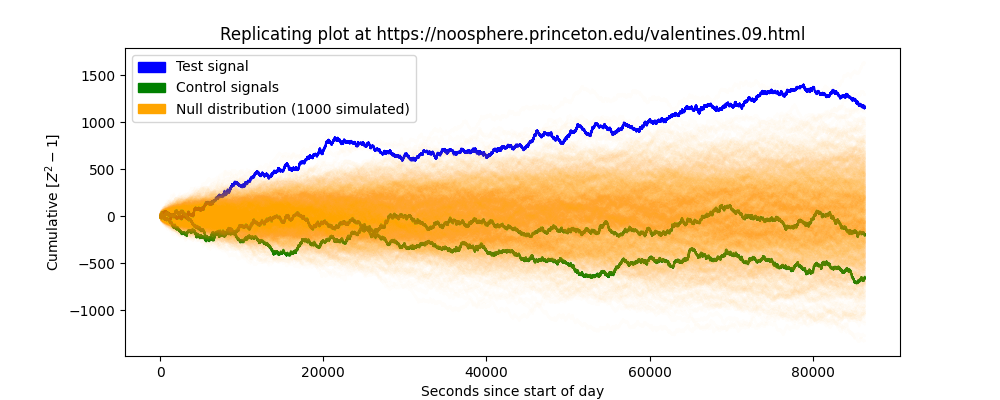

In [10]:
#%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
matplotlib.use('agg') #needed to prevent mem leak sigh
import matplotlib.patches as mpatches

#replicate the figure at https://global-mind.org/valentines.09.html
fig = plt.figure(figsize=(10,4))
plt.plot(np.arange(len(csm1_test)),np.cumsum(csm1_test), color="blue")
plt.plot(np.arange(len(csm1_control1)),np.cumsum(csm1_control1), color="green")
plt.plot(np.arange(len(csm1_control1)),np.cumsum(csm1_control2), color="green")

#also plot 1000 simulated controls from pseudorandom data
rng = np.random.RandomState(1234)
for i in range(1000):
  sim_csm1 = np.square(rng.normal(size=len(csm1_test)))-1
  plt.plot(np.arange(len(sim_csm1)),np.cumsum(sim_csm1), color="orange", alpha=0.02)
plt.title("Replicating plot at https://noosphere.princeton.edu/valentines.09.html")
plt.xlabel("Seconds since start of day")
plt.ylabel("Cumulative [$Z^2 - 1$]")
plt.legend(handles=[mpatches.Patch(color='blue', label='Test signal'),
                    mpatches.Patch(color='green', label='Control signals'),
                    mpatches.Patch(color='orange', label='Null distribution (1000 simulated)')],
           loc="upper left")
fig.savefig('csm1plot.png')
plt.close(fig)
plt.clf()

from IPython.display import Image
Image('csm1plot.png')

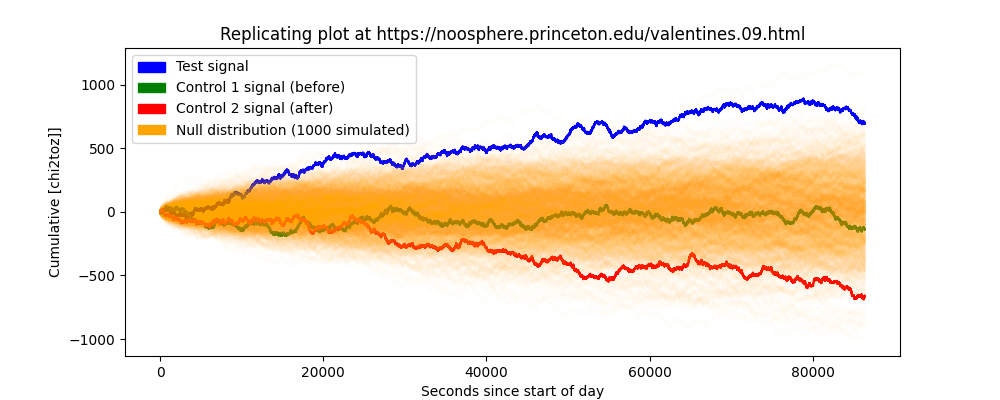

In [54]:
#%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
matplotlib.use('agg') #needed to prevent mem leak sigh
import matplotlib.patches as mpatches

#replicate the figure at https://global-mind.org/valentines.09.html
fig = plt.figure(figsize=(10,4))
plt.plot(np.arange(len(csm1_test)),np.cumsum(chi2toz_test), color="blue")
plt.plot(np.arange(len(csm1_control1)),np.cumsum(chi2toz_control1), color="green")
plt.plot(np.arange(len(csm1_control1)),np.cumsum(chi2toz_control2), color="red")

#also plot 1000 simulated controls from pseudorandom data
rng = np.random.RandomState(1234)
for i in range(1000):
  sim_chi2toz = rng.normal(size=len(csm1_test))
  plt.plot(np.arange(len(sim_csm1)),np.cumsum(sim_chi2toz), color="orange", alpha=0.02)
plt.title("Replicating plot at https://noosphere.princeton.edu/valentines.09.html")
plt.xlabel("Seconds since start of day")
plt.ylabel("Cumulative [chi2toz]]")
plt.legend(handles=[mpatches.Patch(color='blue', label='Test signal'),
                    mpatches.Patch(color='green', label='Control 1 signal (before)'),
                    mpatches.Patch(color='red', label='Control 2 signal (after)'),
                    mpatches.Patch(color='orange', label='Null distribution (1000 simulated)')],
           loc="upper left")
fig.savefig('csm1plot.png')
plt.close(fig)
plt.clf()

from IPython.display import Image
Image('csm1plot.png')

In [11]:
scipy.stats.norm.ppf(scipy.stats.chi2.cdf(df=len(chi2toz_test),
                     x=np.sum(scipy.stats.chi2.ppf(df=1, q=scipy.stats.norm.cdf(chi2toz_test)))
                     ))

2.7878080808655072

In [12]:
print(np.sum(np.square(zsumeggs_test) - 1)/np.sqrt(2*len(zsumeggs_test)) )

2.7981440240374926


In [13]:
print(np.sum(scipy.stats.chi2.ppf(df=1, q=scipy.stats.norm.cdf(chi2toz_test))-1) /np.sqrt(2*len(chi2toz_test)) )

2.7986698322141597


In [48]:
print(np.sum(chi2toz_test)/np.sqrt(len(chi2toz_test)))

2.3900776535125345


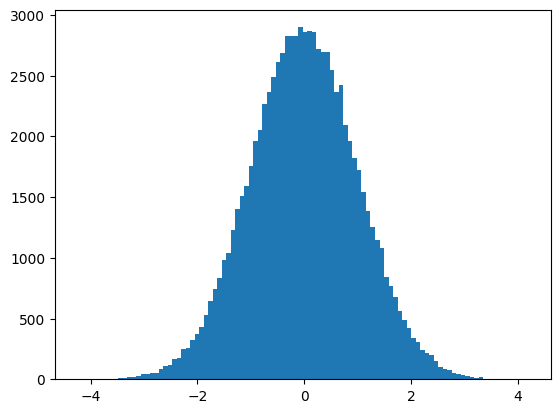

In [49]:
%matplotlib inline

plt.hist(chi2toz_control2, bins=100)
plt.show()

In [41]:
np.mean(chi2toz_control2)

-0.007319161401588882

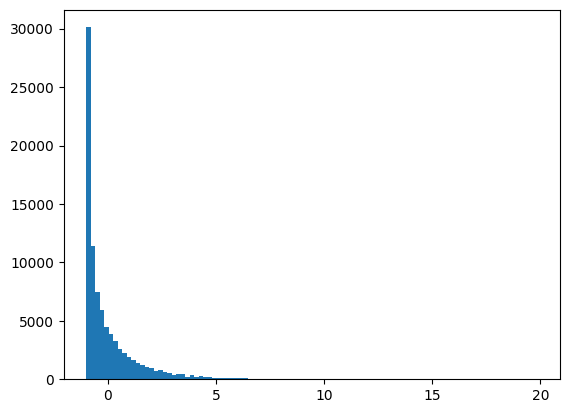

In [19]:
%matplotlib inline

plt.hist(csm1_test, bins=100)
plt.show()

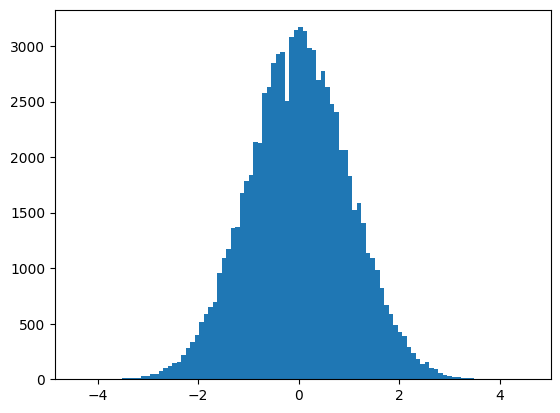

In [20]:
%matplotlib inline

plt.hist(zsumeggs_test, bins=100)
plt.show()

In [55]:
rfft_test = scipy.fft.rfft(chi2toz_test)

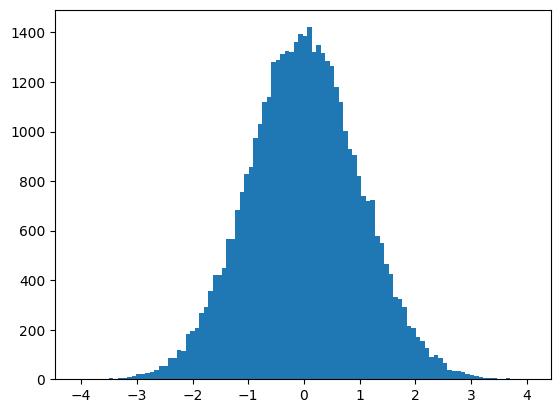

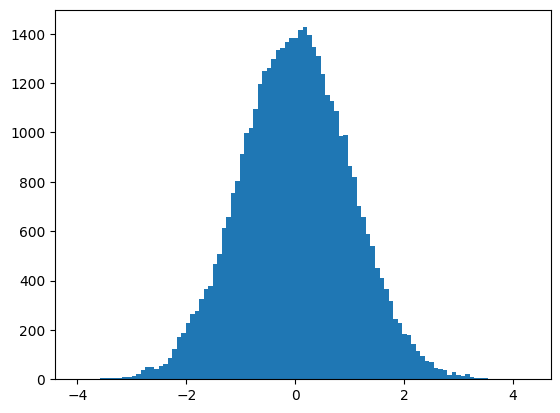

In [57]:
%matplotlib inline

plt.hist(np.real(rfft_test)/np.sqrt(len(chi2toz_test)/2), bins=100)
plt.show()
plt.hist(np.imag(rfft_test)/np.sqrt(len(chi2toz_test)/2), bins=100)
plt.show()

In [58]:
np.std(np.real(rfft_test))

208.440322044884

In [59]:
np.sqrt(len(chi2toz_test)/2)

207.84609690826528

In [62]:
import scipy
#let's check if the normalized power spectrum of the data shows any biases

def get_normalized_power_spectrum(signal):
  rfft = scipy.fft.rfft(signal)
  #https://dsp.stackexchange.com/questions/24170/what-are-the-statistics-of-the-discrete-fourier-transform-of-white-gaussian-nois
  return np.square(np.abs(rfft))/(len(signal)/2)

#nps_test = get_chisqnormalized_power_spectrum(chi2toz_test)
#nps_control1 = get_chisqnormalized_power_spectrum(chi2toz_control1)
#nps_control2 = get_chisqnormalized_power_spectrum(chi2toz_control2)

nps_test = get_normalized_power_spectrum(zsumeggs_test)
nps_control1 = get_normalized_power_spectrum(zsumeggs_control1)
nps_control2 = get_normalized_power_spectrum(zsumeggs_control2)

#permute the test data sequence 1000 times to get an empirical null
rng = np.random.RandomState(1234)
nps_permutetest_2darr = np.array([
    get_normalized_power_spectrum(rng.permutation(zsumeggs_test))
    for i in range(1000)])

freqs =  scipy.fft.rfftfreq(len(chi2toz_test),1)


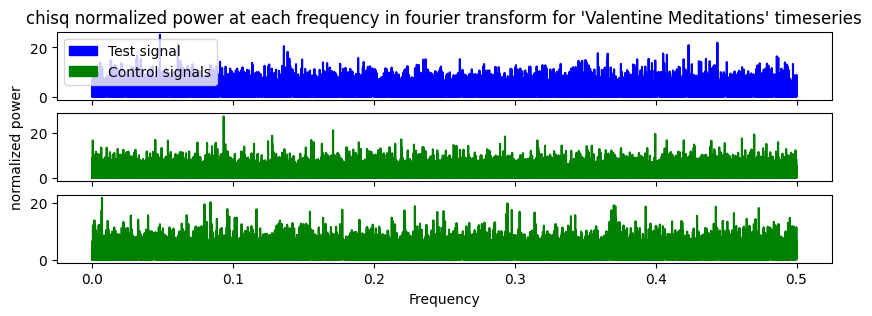

In [63]:
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches

%matplotlib inline

fig, ax = plt.subplots(3, sharex=True, figsize=(10,3))
plt.sca(ax[0])
plt.plot(freqs, nps_test, color='blue', alpha=1)
plt.legend(handles=[mpatches.Patch(color='blue', label='Test signal'),
                    mpatches.Patch(color='green', label='Control signals')],
           loc="upper left")
#plt.ylabel("Relative power fraction")
#plt.xlabel("Frequency")
plt.title("chisq normalized power at each frequency in fourier transform for 'Valentine Meditations' timeseries")
plt.sca(ax[1])
plt.plot(freqs, nps_control1, color='green', alpha=1)
plt.ylabel("normalized power")
#plt.xlabel("Frequency")
plt.sca(ax[2])
plt.plot(freqs, nps_control2, color='green', alpha=1)
#plt.ylabel("Relative power fraction")
plt.xlabel("Frequency")
plt.show()

#plt.figure(figsize=(10,1.5))
#plt.plot(freqs, np.cumsum(rps_test), color="blue", linewidth=1)
#plt.plot(freqs, np.cumsum(rps_control1), color="green", linewidth=1)
#plt.plot(freqs, np.cumsum(rps_control2), color="green", linewidth=1)
#plt.ylabel("Cumulative\npower fraction")
#plt.xlabel("Frequency")
#plt.title("Cumulative fraction of power at each frequency in fourier transform for 'Valentine Meditations' timeseries")
#plt.legend(handles=[mpatches.Patch(color='blue', label='Test signal'),
#                    mpatches.Patch(color='green', label='Control signals')],
#           loc="upper left")
#plt.show()

In [69]:
np.sum(nps_test - 2)/np.sqrt(4*len(nps_test))

2.800194855206742

In [70]:
np.sum(nps_control1 - 2)/np.sqrt(4*len(nps_test))

-0.47820491338908355

In [71]:
np.sum(nps_control2 - 2)/np.sqrt(4*len(nps_test))

-1.5594362239339423

windowsize: 540


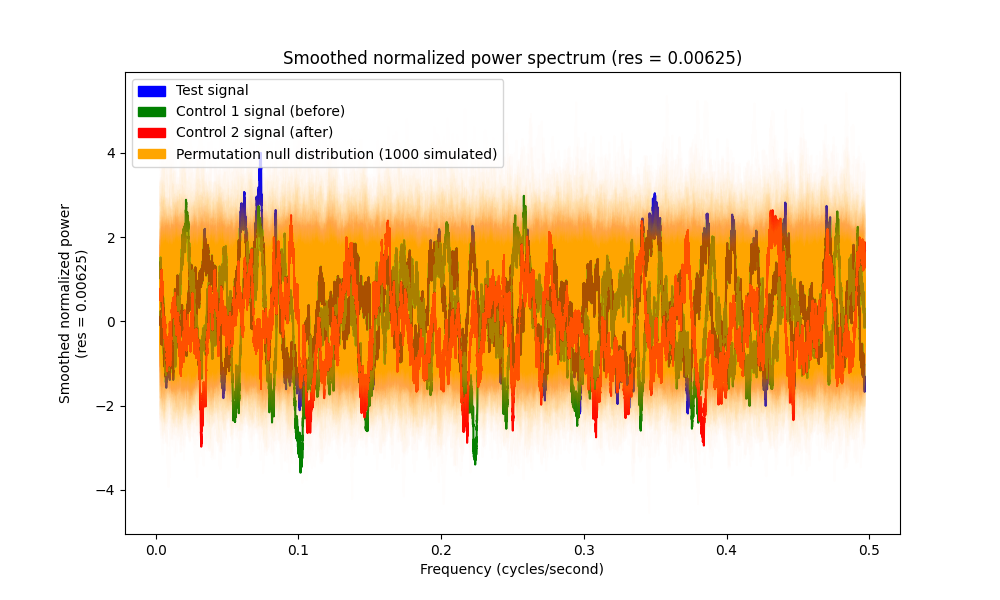

In [66]:
#plot a smoothed power spectrum
def get_smoothed_arr(arr, windowsize):
  arr_cumsum = np.array([0] + list(np.cumsum(arr)))
  smooth_arr = arr_cumsum[windowsize:] - arr_cumsum[:-windowsize]
  return smooth_arr

def get_normalized_smoothedps_arr(arr, windowsize):
  arr_cumsum = np.array([0] + list(np.cumsum(arr)))
  smooth_arr = arr_cumsum[windowsize:] - arr_cumsum[:-windowsize]
  #Since the windows are a sum of chisq distributed rvs, we can map
  # to a standard normal dist by subtracting windowsize and dividing by sqrt(2*windowsize),
  # assuming windowsize is relatively large
  smooth_arr = (smooth_arr - 2*windowsize)/np.sqrt(4*windowsize)
  return smooth_arr

def get_normalized_smoothedps_arrs(arrs, windowsize):
  arr_cumsum = np.pad(np.cumsum(arrs, axis=1), ((0,0),(1,0)))
  smooth_arr = arr_cumsum[:,windowsize:] - arr_cumsum[:,:-windowsize]
  smooth_arr = (smooth_arr - 2*windowsize)/np.sqrt(4*windowsize)
  return smooth_arr


FREQSMOOTH = 0.00625
freq_stepsize = freqs[1]
windowsize = int(FREQSMOOTH/freq_stepsize)
print("windowsize:",windowsize)

smooth_rps_test = get_normalized_smoothedps_arr(nps_test, windowsize)
smooth_rps_control1 = get_normalized_smoothedps_arr(nps_control1, windowsize)
smooth_rps_control2 = get_normalized_smoothedps_arr(nps_control2, windowsize)
smooth_rps_permutetest_2darr = get_normalized_smoothedps_arrs(nps_permutetest_2darr, windowsize)

#plot the smoothed spectra
smooth_xaxis = get_smoothed_arr(freqs, windowsize)/windowsize

#Oh hm, I guess independence assumption is broken because the power will
# end up summing up to a particular value...

matplotlib.use('agg') #needed to prevent mem leak sigh
fig = plt.figure(figsize=(10,6))
plt.plot(smooth_xaxis, smooth_rps_test, color="blue")
plt.plot(smooth_xaxis, smooth_rps_control1, color="green")
plt.plot(smooth_xaxis, smooth_rps_control2, color="red")
#Also plot the 1000 power spectra from the permuted test data
for smooth_rps_permutetest in smooth_rps_permutetest_2darr:
  plt.plot(smooth_xaxis, smooth_rps_permutetest, color="orange", alpha=0.01)
plt.ylabel("Smoothed normalized power\n(res = "+str(FREQSMOOTH)+")")
plt.xlabel("Frequency (cycles/second)")
plt.title("Smoothed normalized power spectrum (res = "+str(FREQSMOOTH)+")")
plt.legend(handles=[mpatches.Patch(color='blue', label='Test signal'),
                    mpatches.Patch(color='green', label='Control 1 signal (before)'),
                    mpatches.Patch(color='red', label='Control 2 signal (after)'),
                    mpatches.Patch(color='orange', label='Permutation null distribution (1000 simulated)')],
           loc="upper left")
fig.savefig('smooth_nps.png')
plt.close(fig)
plt.clf()

from IPython.display import Image
Image("smooth_nps.png")